In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle, gzip, uuid

from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [7]:
def benchmark(model, trainX, trainY, testX, testY, arg = None):
  m = model() if arg == None else model(n_jobs=arg)
  m.fit(trainX, np.ravel(trainY))
  return m, classification_report(testY, m.predict(testX))

In [8]:
data_path = "./data"
train_set_name = ["A","B","C","D","E"]
verify_set_name = ["X", "Y", "Z"]
classifiers = [
  ("决策树", DecisionTreeClassifier),
  ("高斯朴素贝叶斯", GaussianNB),
  ("K临近", KNeighborsClassifier),
]

In [9]:
# Load training dataset
raw_features = []
labels = []
for name in train_set_name:
  feat = pd.read_table("{}/{}/{}.feature".format(data_path, name, name), sep=',', low_memory=False)
  label = pd.read_table("{}/{}/{}.label".format(data_path, name, name), sep=',')
  raw_features.append(feat)
  labels.append(label)
  print("dataset {} loaded".format(name))

# Transform training dataset
features = []
for name, feat in zip(train_set_name, raw_features):
  feat = feat.replace('?', 0)
  imp_mean = SimpleImputer(missing_values=0, strategy='mean')
  imp_mean.fit(feat)
  feat = imp_mean.transform(feat)
  features.append(feat)
  print("feature {} tranformed {}".format(name, feat.shape))
del raw_features

train_setX = np.vstack(features[0:4])
train_setY = np.vstack(labels[0:4])
print("trainset feature {} label {}".format(train_setX.shape, train_setY.shape))
test_setX = np.array(features[-1])
test_setY = np.array(labels[-1])
print("testset feature {} label {}".format(test_setX.shape, test_setY.shape))

# Load verify dataset
verify_set = []
for name in verify_set_name:
  feat = pd.read_table("{}/{}/{}.feature".format(data_path, name, name), sep=',', low_memory=False)
  verify_set.append(feat)
  print("verify set {} loaded".format(name))

# Transform verify dataset
verify_features = []
for name, feat in zip(verify_set_name, verify_set):
  feat = feat.replace('?', 0)
  imp_mean = SimpleImputer(missing_values=0, strategy='mean')
  imp_mean.fit(feat)
  feat = imp_mean.transform(feat)
  verify_features.append(feat)
  print("feature {} tranformed {}".format(name, feat.shape))

dataset A loaded
dataset B loaded
dataset C loaded
dataset D loaded
dataset E loaded
feature A tranformed (376416, 41)
feature B tranformed (408030, 41)
feature C tranformed (252832, 41)
feature D tranformed (329575, 41)
feature E tranformed (374782, 41)
trainset feature (1366853, 41) label (1366853, 1)
testset feature (374782, 41) label (374782, 1)
verify set X loaded
verify set Y loaded
verify set Z loaded
feature X tranformed (313598, 41)
feature Y tranformed (361816, 41)
feature Z tranformed (446999, 41)


In [10]:
training_size = -1
test_size = -1

# Train models
models = []
reports = []
for name, c in classifiers:
  print(name)
  if name == "K临近":
    model, report = benchmark(c, train_setX[:training_size],
    train_setY[:training_size], test_setX[:test_size], test_setY[:test_size],
    -1)
  else:
    model, report = benchmark(c, train_setX[:training_size],
    train_setY[:training_size], test_setX[:test_size], test_setY[:test_size])
  reports.append(report)
  models.append(model)

for cf, rep in zip(classifiers, reports):
  print(cf[0])
  print(rep)

# dump results
with gzip.open("model{}.pkl.gz".format(str(uuid.uuid4())), 'wb') as f:
  pickle.dump(models, f)
with gzip.open("report{}.pkl.gz".format(str(uuid.uuid4())), 'wb') as f:
  pickle.dump(reports, f)

决策树
高斯朴素贝叶斯
K临近
决策树
              precision    recall  f1-score   support

           0       0.51      0.75      0.61    102340
           1       0.66      0.96      0.78     23699
           2       0.89      0.84      0.86     26864
           3       0.93      0.72      0.81     22132
           4       0.63      0.87      0.73     32033
           5       0.76      0.85      0.80     24646
           6       0.19      0.01      0.02     24577
           7       0.63      0.15      0.24     26271
          12       0.60      0.65      0.63     14281
          13       0.66      0.48      0.56     12727
          16       0.57      0.07      0.13     24445
          17       0.85      0.85      0.85     33034
          24       0.35      0.31      0.33      7732

    accuracy                           0.64    374781
   macro avg       0.63      0.58      0.57    374781
weighted avg       0.63      0.64      0.59    374781

高斯朴素贝叶斯
              precision    recall  f1-score   suppo

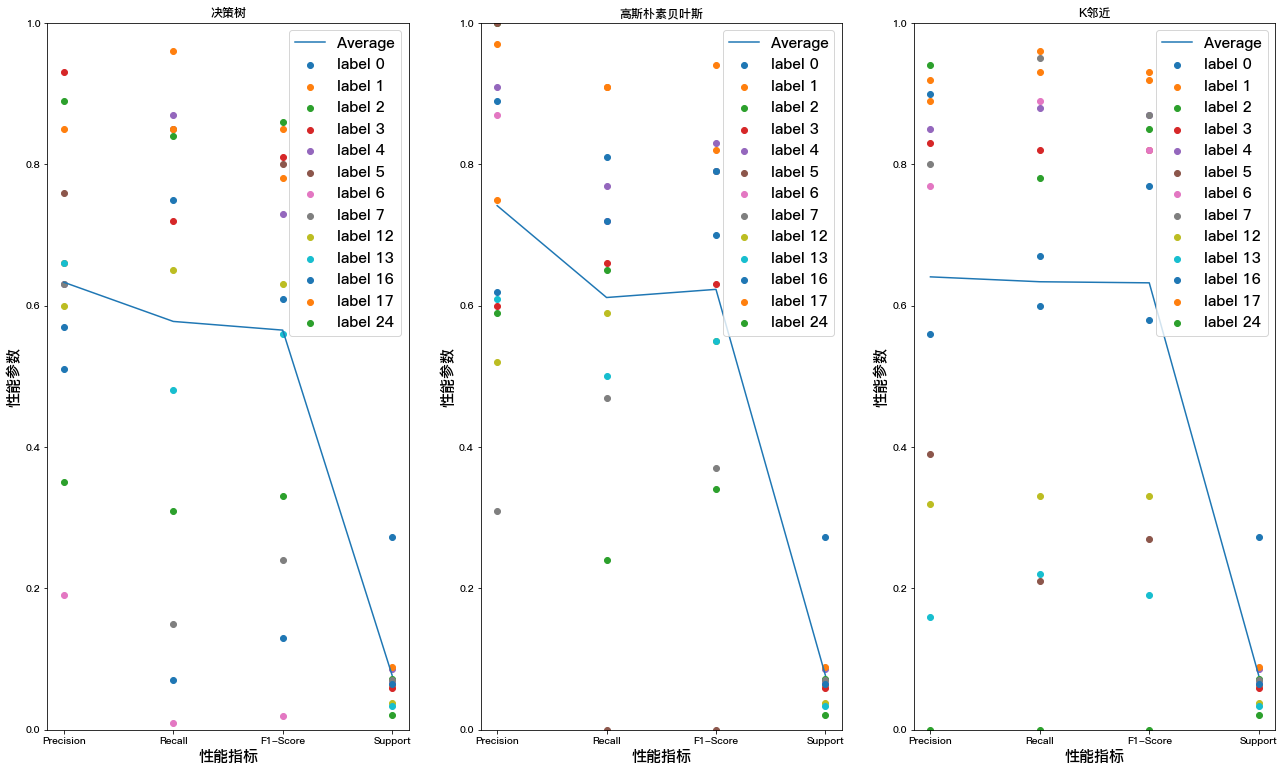

In [20]:
rep = pd.read_csv("report.csv", sep=',')
plt.rcParams['font.sans-serif'] = ["PingFang SC"]
plt.rcParams["figure.figsize"] = (22, 13)
fontsize = 15
names = ["决策树", "高斯朴素贝叶斯", "K邻近"]
labels = [0, 1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24]
indexs = ["Precision", "Recall", "F1-Score", "Support"]
for i in range(3):
  # plt.figure(i)
  plt.subplot(1,3,i+1)
  r = np.array(rep.iloc[(0+i)*13:(1+i)*13, :])
  mean = r.mean(axis=0)
  mean[-1] = mean[-1]/374781
  plt.plot(indexs, mean)
  for y in r:
    y[-1] = y[-1]/374781
    plt.scatter(indexs, y)
    plt.title(names[i])
    plt.xlabel("性能指标", fontsize=fontsize)
    plt.ylabel("性能参数", fontsize=fontsize)
    plt.ylim([0,1])
    plt.legend(["Average"]+["label {}".format(label) for label in labels], fontsize=fontsize)
plt.show()